**This notebook contains all experiments conducted using VGGish as feature extractor.**

# Load data and global functions

In [1]:
import librosa
import librosa.display
import numpy as np
import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize
from torchvggish import vggish, vggish_input
import random
import skimage as ski
from matplotlib import transforms

# Prevent Kernel from dying
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Select cuda if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load data

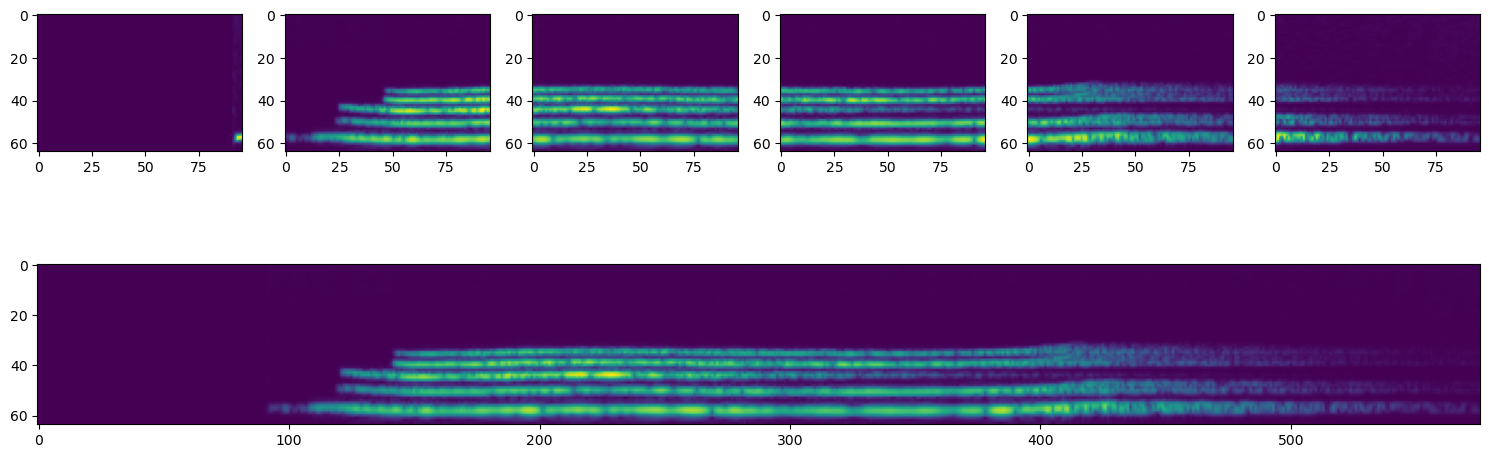

In [2]:
# Load an audio file 
audio_path = 'data/whale.mp3'
y, sr  = librosa.load(audio_path)

# Prepare input
x = vggish_input.waveform_to_examples(y, sr)
(n_frames, n_channels, h, w) = x.shape
full_length = n_frames * h
min_value = torch.min(x)

# Concatenate and split
x_full = torch.cat(tuple(x), dim=1)
x_split = x_full.view(1, n_frames, 96, 64)

# Plot
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, n_frames) # define the grid layout
for i in range(n_frames):
    ax_upr = fig.add_subplot(gs[0, i])
    ax_upr.imshow(np.rot90(x_split[0,i,:,:].detach().numpy()))
ax_lwr = fig.add_subplot(gs[1, :])
ax_lwr.imshow(np.rot90(x_full[0,:,:].detach().numpy()))
plt.tight_layout()
plt.show()

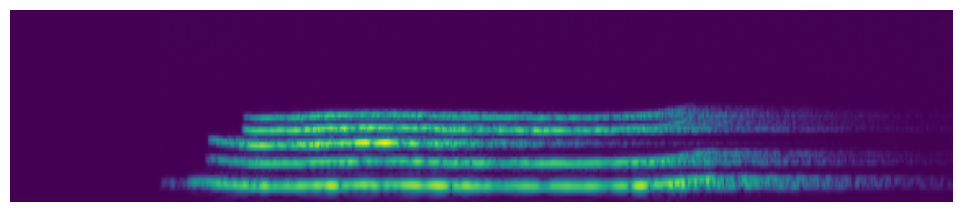

In [3]:
# Save figure for report plot
fig = plt.figure(figsize=(10, 2.5))

plt.imshow(np.rot90(x_full[0,:,:].detach().numpy()), aspect = 'auto')
plt.tight_layout()

plt.axis('off')
fig.savefig(f'sample_whale.png', dpi=300, bbox_inches='tight')
plt.show()

## Segmentation algorithm

In [4]:
# Choose segmentation
segments = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 50)
#segments = ski.segmentation.slic(x_full[0,:,:].detach().numpy(), n_segments=250, compactness=0.1, sigma = 1 , start_label=0, channel_axis=None)
n_segments = np.max(segments)
print('Number of segments: \t', n_segments)
print('Segments shape: \t', segments.shape)

#plt.imshow(np.rot90(segments), aspect='auto')
#plt.show()

Number of segments: 	 130
Segments shape: 	 (576, 64)


## Model

In [5]:
# Load model
model = vggish() 
model_name = 'VGGish'

# Apply model
out = model(x)

print('Input shape:\t', x.shape)
print('Output shape:\t', out.shape)

Input shape:	 torch.Size([6, 1, 96, 64])
Output shape:	 torch.Size([6, 128])


## Insertion/Deletion plot

In [6]:
def insertion_deletion_plot_VGGish(importance_mat, uncertainty_mat, model, x, x_full):
    pdist = nn.CosineSimilarity(dim=1)
    t = importance_mat.shape[0]
    f = importance_mat.shape[1]
    min_x = x.min()
    insert_list = []
    delete_list = []
    percent_idx_list = 100*np.cumsum([t for _ in range(f)]) / (t*f)
    
    with torch.no_grad():
        h_star = model(x) # [3, 128]
        imp_mat_flat = importance_mat.flatten() # [18432], 96*64*3

        for i in range(f):
            top_k = torch.topk(imp_mat_flat, t*(i+1))
            replace_mask_top = (importance_mat > top_k.values[t*(i+1)-1])
            replace_mask_bottom = (importance_mat <= top_k.values[t*(i+1)-1])

            #Insertion:
            new_x_ins = replace_mask_top * x_full[0,:,:] + min_x * replace_mask_bottom
            new_x_ins = new_x_ins.view(n_frames,1, 96, 64)
            h_ins = model(new_x_ins)
            s_ins = pdist(h_star, h_ins)
            insert_list.append(torch.mean(s_ins))

            #Deletion:
            new_x_del = replace_mask_bottom *  x_full[0,:,:] + min_x * replace_mask_top
            new_x_del = new_x_del.view(n_frames,1, 96, 64)
            h_del = model(new_x_del)
            s_del = pdist(h_star, h_del)
            delete_list.append(torch.mean(s_del))
    
    fig = plt.figure(figsize=(10, 3))

    #Define axis positions
    ax1 = fig.add_axes([0.05, 0.5, 0.6, 1])
    ax2 = fig.add_axes([0.05, 0.1, 0.6, 1])
    ax3 = fig.add_axes([0.7, 0.53, 0.3, 0.6])
    ax = [ax1, ax2, ax3]

    #Plotting importance and uncertainty
    R = importance_mat
    U = uncertainty_mat
    ax1.imshow(np.rot90(x_full.detach().numpy()[0,:,:]),cmap = 'gray')
    ax2.imshow(np.rot90(x_full.detach().numpy()[0,:,:]),cmap = 'gray')
    im0 = ax1.imshow(np.rot90(R.cpu()),  cmap='bwr', alpha=0.7)
    im1 = ax2.imshow(np.rot90(U.cpu()),  cmap='bwr', alpha=0.7)
    fig.subplots_adjust(right=0.8)

    #Positioning colorbar
    cbar_ax = fig.add_axes([0.66, 0.5, 0.015, 0.6])
    cbar = fig.colorbar(im0, cax=cbar_ax)
    cbar.ax.set_yticks([])
    ax1.set_title('Importance')
    ax2.set_title('Uncertainty')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    #Model name on the left of the plot
    fig.text(0.03, 0.8, 'VGGish', va='center', rotation='vertical', fontsize=12)
    
    #Plotting insertion/deletion
    ax3.plot(percent_idx_list, insert_list, label='Insertion')
    ax3.grid(which='both', linestyle='--', linewidth=0.5)
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    ax3.set_ylabel('Cosine similarity')
    ax3.set_xlabel('percentage of pixels inserted/deleted')
    ax3.plot(percent_idx_list, delete_list, label='Deletion', color='red')
    ax3.legend()
    plt.show()
    return fig, ax

In [7]:
def insertion_deletion_plot_segments_VGGish(importance_mat, segment_mat, model, x, x_full):

    pdist = nn.CosineSimilarity(dim=1)
    t = importance_mat.shape[0]
    f = importance_mat.shape[1]
    num_segments = segment_mat.max() + 1
    min_x = x.min()
    insert_list = []
    delete_list = []

    sim_list = sorted([importance_mat[ segment_mat == i ][0] for i in range(num_segments)], reverse=True)
    seq_size_list = [(importance_mat == sim_list[i]).sum() for i in range(num_segments)]
    percent_idx_list = 100*np.cumsum(seq_size_list) / (t*f)

    with torch.no_grad():
        h_star = model(x) # [1, 768]

        for i in range(num_segments):
            replace_mask = (importance_mat >= sim_list[i])

            #Insertion:
            new_x_ins = replace_mask *  x_full[0,:,:] + min_x * ~replace_mask
            new_x_ins = new_x_ins.view(n_frames,1, 96, 64)
            h_ins = model(new_x_ins)
            s_ins = pdist(h_star, h_ins)
            insert_list.append(torch.mean(s_ins))

            #Deletion:
            new_x_del = ~replace_mask *  x_full[0,:,:]+ min_x * replace_mask
            new_x_del = new_x_del.view(n_frames,1, 96, 64)
            h_del = model(new_x_del)
            s_del = pdist(h_star, h_del)
            delete_list.append(torch.mean(s_del))

    fig, ax = plt.subplots(1,2, figsize=(10,3))

    ax[0].plot(percent_idx_list, insert_list)
    ax[0].set_title('Insertion curve (VGGish)')
    ax[0].set_ylabel('Cosine similarity')
    ax[0].set_xlabel('Percentage of pixels inserted')
    ax[1].plot(percent_idx_list, delete_list)
    ax[1].set_title('Deletion curve (VGGish)')
    ax[1].set_ylabel('Cosine similarity')
    ax[1].set_xlabel('Percentage of pixels deleted')

    return fig, ax

# Up-Sampled Grid Mask 

In [14]:
class MaskGenerator:
    def __init__(self, shape, mask_type="original", mask_percentage=30, mask_bs=1):
        self.shape = shape #(time, freq), (1024, 128)
        self.mask_type = mask_type
        self.mask_percentage = mask_percentage
        self.mask_bs = mask_bs
        
    def generate(self):
        masks = torch.ones((self.mask_bs, *self.shape))
        patch_size = 2
        
        for idx in range(self.mask_bs):
            mask = masks[idx]
            if self.mask_type == "original":
                continue

            elif self.mask_type == "RELAX":
                ps = 32
                pad_size = (ps,ps,ps,ps)
                #Grid der interpoleres op til size self.shape dimensioner styrer 'formen' af masken
                grid = (torch.rand(self.mask_bs, 1, 10,10, device='cpu') > self.mask_percentage/100).float()
                grid_up = F.interpolate(grid, size=(1024,1024), mode='bilinear', align_corners=False)
                grid_up = F.pad(grid_up, pad_size, mode='reflect')
                shift_x = np.random.randint(0,ps)
                shift_y = np.random.randint(0,1024-128)
                mask[:,:] = grid_up[0, :, shift_x:shift_x + self.shape[0], shift_y:shift_y + self.shape[1]]
            else:
                raise ValueError(f"Invalid mask type {self.mask_type}")

        return masks

 ### Plot example mask

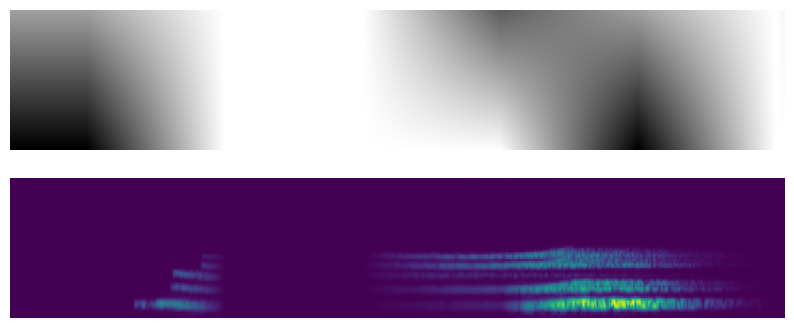

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
INPUT_SHAPE = (full_length, 64)
MASK_BS = 1
MIN_VALUE = torch.min(x)
mask_gen = MaskGenerator(INPUT_SHAPE, mask_type = "RELAX", mask_percentage=40, mask_bs=MASK_BS)
batch_masks = mask_gen.generate()
mask = batch_masks[0] 
diff_mat = (x_full-MIN_VALUE)
x_mask = x_full-diff_mat * mask
axs[1].imshow(np.rot90(x_mask.detach().numpy()[0,:,:]), cmap = 'viridis', aspect='auto')
axs[0].imshow(np.rot90(mask.detach().numpy()[:,:]), cmap = 'gray', aspect='auto')
axs[0].axis('off')
axs[1].axis('off')
fig.savefig(f'upsampledgrid.png', dpi=300, bbox_inches='tight')
plt.show()

### Run RELAX

In [ ]:
import tqdm.notebook as tqdm

# Model
model = vggish() 
model_name = 'VGGish'
h_star = model(x)

# Adjustable parameters
MASK_PERCENTAGE = 50
MASKE_TYPE = "RELAX"
NUM_BATCHES = 50*400
MASK_BS = 1
INPUT_SHAPE = (full_length, 64)
MIN_VALUE = torch.min(x)
diff_mat = (x_full-MIN_VALUE)

# Initialize arrays
R = torch.zeros(576, 64)
U = torch.zeros(576, 64)

# Similarity measure
pdist = nn.CosineSimilarity(dim=1)

with torch.no_grad():
    # Calculate Importance
    for batch_idx in tqdm.trange(NUM_BATCHES, desc=f"Processing batches for {model_name} importance"):
        mask_gen = MaskGenerator(shape = INPUT_SHAPE, mask_type=MASKE_TYPE, mask_percentage=MASK_PERCENTAGE, mask_bs=MASK_BS)
        batch_masks = mask_gen.generate()
        
        # Apply mask
        mask = batch_masks[0]
        x_mask = x_full-diff_mat * mask
        x_mask = x_mask.view(6, 1, 96, 64)
        
        # Compute output for masked input
        h = model(x_mask)
        
        # Compute cosine similarity
        s = pdist(h_star, h)[:, None, None, None]             
        
        # Compute importance
        R += torch.mean(s * (1-mask), dim=(0, 1))
    
    R/=(NUM_BATCHES*(MASK_PERCENTAGE/100))
    
    # Calculate Uncertainty
    for batch_idx in tqdm.trange(NUM_BATCHES, desc=f"Processing batches for {model_name} uncertainty"):
        mask_gen = MaskGenerator(shape = INPUT_SHAPE, mask_type=MASKE_TYPE, mask_percentage=MASK_PERCENTAGE, mask_bs=MASK_BS)
        batch_masks = mask_gen.generate()
        
        # Apply mask
        mask = batch_masks[0]
        x_mask = x_full-diff_mat * mask
        x_mask = x_mask.view(6, 1, 96, 64)
        
         # Compute output for masked input
        out = model(x_mask)
        
        # Compute cosine similarity
        s = pdist(h_star, out)[:, None, None, None]

        
        # Compute uncertainty
        var = (s-R)**2
        var = torch.mean(var * (1-mask), dim=(0, 1))

        U += var
        
    U /=  ((NUM_BATCHES-1)*(MASK_PERCENTAGE/100))

### Plot 

In [ ]:
mask_type = 'Upsampled_grid_mask'
algo = 'RELAX'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

# Segmentation-based Masking

## Experiment: Deterministic approach/SINEX

In [12]:
# Precomputations
pdist = nn.CosineSimilarity(dim=1)
h_star = model(x)
R, U = torch.zeros(full_length, w), torch.zeros(full_length, w)
segments = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 50)

# Loop through segments
with torch.no_grad():
    for i in range(n_segments):
        mask = torch.from_numpy(segments == i).float()
        mask_size = mask.sum() 

        # Apply mask
        x_mask = x_full * mask
        x_mask[x_mask == 0] = min_value  
        
        x_mask = x_mask.view(x.shape)
        
        h = model(x_mask)
        s = pdist(h_star, h)[:, None, None, None]
        
        R += torch.mean(torch.cat(tuple(s*mask.view(x.shape)), dim=1), dim=(0)) / mask_size

### Insertion deletion plot

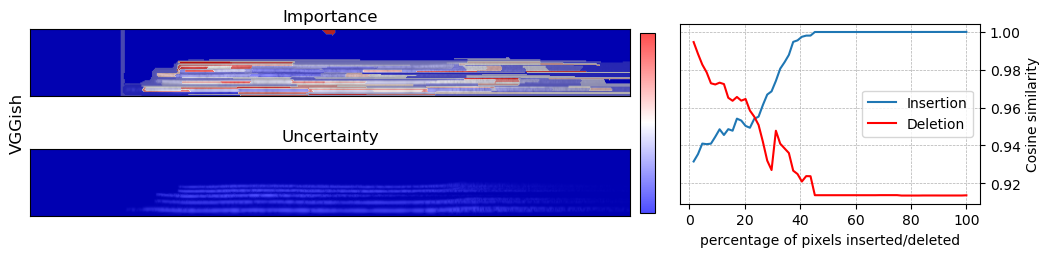

In [13]:
U = torch.zeros(576, 64)

mask_type = 'Felsenswalp'
algo = 'SINEX'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

## Experiment: Random selection of segments

In [18]:
class MaskGenerator:
    def __init__(self, SEG_mat, shape, mask_type="original", mask_percentage=30, mask_bs=1):
        self.SEG_mat = SEG_mat
        self.shape = shape
        self.mask_type = mask_type
        self.mask_percentage = mask_percentage
        self.mask_bs = mask_bs

    def generate(self):
        # Initialize masks with an extra dimension for the channel
        masks = torch.ones((self.mask_bs, 1, *self.shape), dtype=torch.float32)
        num_segments = np.max(self.SEG_mat) + 1
        total_area = self.shape[0] * self.shape[1]
        target_unmasked_area = total_area * (self.mask_percentage / 100)

        for idx in range(self.mask_bs):
            mask = masks[idx, 0]  # Access the first channel
            if self.mask_type == "original":
                continue
            elif self.mask_type == "randomSegments":
                unmasked_area = 0
                segments = list(range(num_segments))
                random.shuffle(segments)

                for segment_id in segments:
                    segment_area = np.sum(self.SEG_mat == segment_id)

                    if unmasked_area + segment_area <= target_unmasked_area:
                        mask[self.SEG_mat == segment_id] = 0
                        unmasked_area += segment_area
                    else:
                        break
            else:
                raise ValueError(f"Invalid mask type {self.mask_type}") 
        return masks

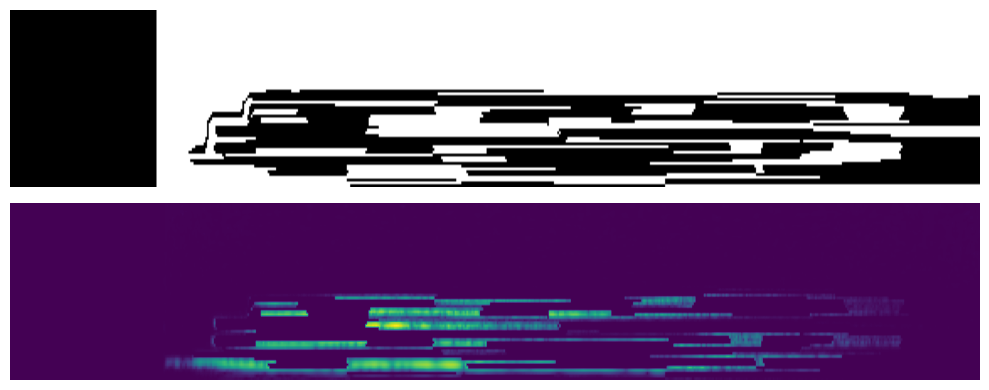

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
INPUT_SHAPE = (full_length, 64)
SEGMENTS = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 50)
MASK_BS = 1
MIN_VALUE = torch.min(x)
mask_gen = MaskGenerator(SEGMENTS, INPUT_SHAPE, mask_type='randomSegments', mask_percentage=70, mask_bs=MASK_BS)
batch_masks = mask_gen.generate()
mask = batch_masks[0]
x_mask=(x_full* (mask))
x_mask[x_mask == 0] = MIN_VALUE

axs[1].imshow(np.rot90((x_mask).detach().numpy()[0,:,:]), cmap = 'viridis', aspect='auto')
axs[0].imshow(np.rot90(mask.detach().numpy()[0,:,:]), cmap = 'gray', aspect='auto')

axs[0].axis('off')
axs[1].axis('off')

plt.tight_layout()
plt.savefig('felz_mask.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Run RELAX

In [22]:
import tqdm.notebook as tqdm

# Output
h_star = model(x)

# Adjustable parameters
NUM_BATCHES = 50*200
SEGMENTS = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 50)
#SEGMENTS = ski.segmentation.slic(x_full[0,:,:].detach().numpy(), n_segments=250, compactness=0.1, sigma = 1 , start_label=0, channel_axis=None)
MASKE_TYPE = "randomSegments"
MASK_PERCENTAGE = 90
MASK_BS = 1
INPUT_SHAPE = (full_length, 64)
MIN_VALUE = torch.min(x)

# Initialize arrays
R = torch.zeros(576, 64)
U = torch.zeros(576, 64)

# Similarity measure
pdist = nn.CosineSimilarity(dim=1)

with torch.no_grad():
    # Calculate Importance
    for batch_idx in tqdm.trange(NUM_BATCHES, desc=f"Processing batches for {model_name} importance"):
        mask_gen = MaskGenerator(SEGMENTS, INPUT_SHAPE, mask_type=MASKE_TYPE, mask_percentage=MASK_PERCENTAGE, mask_bs=MASK_BS)
        batch_masks = mask_gen.generate()
        
        mask = (batch_masks[0] == 1)
        mask_size = torch.sum(mask) 
        
        x_mask = x_full * batch_masks[0]
        x_mask[x_mask == 0] = MIN_VALUE  
        x_mask = x_mask.view(6, 1, 96, 64)
        
        h = model(x_mask)
        s = pdist(h_star, h)[:, None, None, None]
        
        tmp = s * batch_masks[0].view(6, 1, 96, 64)
        #print(torch.cat(tuple(tmp), dim=1).shape)
        
        R += torch.mean(torch.cat(tuple(tmp), dim=1), dim=(0)) / mask_size
    
    R /= (NUM_BATCHES * (MASK_PERCENTAGE / 100))
    
    # Calculate Uncertainty
    for batch_idx in tqdm.trange(NUM_BATCHES, desc=f"Processing batches for {model_name} uncertainty"):
        mask_gen = MaskGenerator(SEGMENTS,INPUT_SHAPE, mask_type=MASKE_TYPE, mask_percentage=MASK_PERCENTAGE, mask_bs=MASK_BS)
        batch_masks = mask_gen.generate()

        x_mask = x_full * batch_masks[0]
        x_mask[x_mask == 0] = MIN_VALUE  
        x_mask = x_mask.view(6, 1, 96, 64)
        
        out = model(x_mask)
        
        s = pdist(h_star, out)[:, None, None, None]

        var = (s-R)**2
        var = torch.mean(var * batch_masks[0], dim=(0, 1))

        U += var
    
    U /= ((NUM_BATCHES - 1) * (MASK_PERCENTAGE / 100))


Processing batches for VGGish importance:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing batches for VGGish uncertainty:   0%|          | 0/10000 [00:00<?, ?it/s]

### Plot results

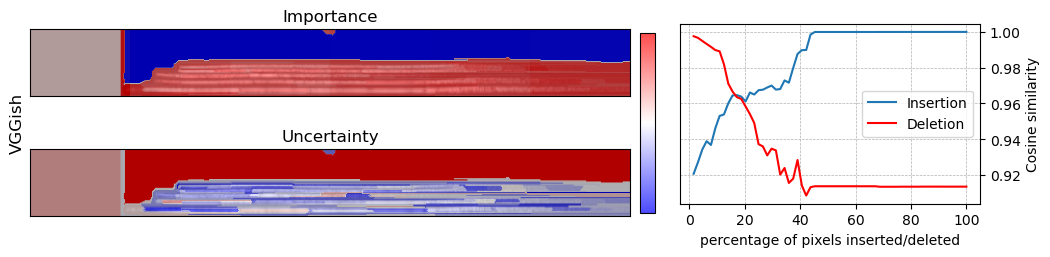

In [23]:
mask_type = 'Random_Felsenswalp'
algo = 'RELAX'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

## Experiment: Selection approach from SINEXC

In [39]:
# Parameters for SINEXC
alpha = 50 #per-segment coalitions # 25, 50, 70, (100)
beta = 0.15 # per-coalition active segments in % value 0.15, 0.30, 0.5

In [38]:
from tqdm import tqdm

def SinexC_VGGish(segment_mat, model, x, x_full, alpha, beta):

    pdist = nn.CosineSimilarity(dim=1)
    t = segment_mat.shape[0]
    f = segment_mat.shape[1]

    R = torch.zeros((t, f), dtype=torch.float32) # Importance
    U = torch.zeros((t, f), dtype=torch.float32) # Uncertainty

    num_segments = np.unique(segment_mat).shape[0]
    min_x = x.min()

    with torch.no_grad():
        h_star = model(x)
        
        # Importance
        for i in tqdm(range(num_segments), desc="Calculating Importance"):
            segment_mask = (segment_mat == i)
            P = np.random.binomial(1, beta, size=(alpha, num_segments))
            s = 0
            
            for p in P:
                extra_masks = np.any([segment_mat == j for j in range(num_segments) if p[j] == 1], axis = 0)
                replace_mask = torch.from_numpy(np.any([segment_mask, extra_masks], axis = 0))
                weight_mask = replace_mask.sum()

                x_new = replace_mask * x_full[0,:,:] + min_x * ~replace_mask
                x_new = x_new.view(n_frames, 1, 96, 64)
                h_new = model(x_new)
                s_new = pdist(h_star, h_new) / weight_mask
                s += s_new

            R += (torch.mean(s) / alpha) * segment_mask
        
        # Uncertainty
        for i in tqdm(range(num_segments), desc="Calculating Uncertainty"):            
            segment_mask = (segment_mat == i)
            P = np.random.binomial(1, beta, size=(alpha, num_segments))
            s = 0
            var = 0
        
            for p in P:
                extra_masks = np.any([segment_mat == j for j in range(num_segments) if p[j] == 1], axis = 0)
                replace_mask = torch.from_numpy(np.any([segment_mask, extra_masks], axis = 0))
                weight_mask = replace_mask.sum()

                x_new = replace_mask * x_full[0,:,:] + min_x * ~replace_mask
                x_new = x_new.view(n_frames, 1, 96, 64)
                h_new = model(x_new)
                s_new = pdist(h_star, h_new)[:, None, None, None]  / weight_mask
                var += (s_new-R)**2 
            U += (1/(alpha-1)) * torch.mean(var*segment_mask, dim = (0,1))
            
    return R, U 

In [40]:
SEGMENTS = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 100)

R, U = SinexC_VGGish(SEGMENTS, model, x, x_full, alpha, beta)

Calculating Uncertainty: 100%|██████████| 56/56 [04:59<00:00,  5.35s/it]


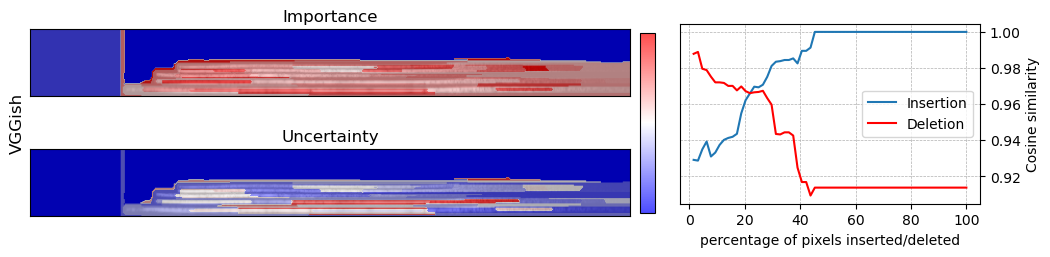

In [42]:
mask_type = 'Felsenswalp'
algo = 'SINEXC'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}_alpha{alpha}_beta{beta}.png', dpi=300, bbox_inches='tight')
plt.show()

# Time/Frequency Masking

### Mask Generator 

In [47]:
class MaskGenerator:
    def __init__(self, shape, mask_type="original", mask_percentage=30, mask_bs=1):
        self.shape = shape
        self.mask_type = mask_type
        self.mask_percentage = mask_percentage
        self.mask_bs = mask_bs
        
    def generate(self):
        masks = torch.ones((self.mask_bs, *self.shape))
        patch_size = 4
        
        for idx in range(self.mask_bs):
            mask = masks[idx]
            if self.mask_type == "original":
                continue

            elif self.mask_type == "unstructured":
                total_patches = (self.shape[0] // patch_size) * (self.shape[1] // patch_size)
                patches_to_mask = int((self.mask_percentage / 100) * total_patches)

                mask_indices = np.random.choice(total_patches, patches_to_mask, replace=False)

                for index in mask_indices:
                    row = (index // (self.shape[1] // patch_size)) * patch_size
                    col = (index % (self.shape[1] // patch_size)) * patch_size
                    mask[row:row+patch_size, col:col+patch_size] = 0

            elif self.mask_type == "frequency":
                total_time_patches = self.shape[1] // patch_size
                patches_to_mask = int((self.mask_percentage / 100) * total_time_patches)

                mask_cols = np.random.choice(total_time_patches, patches_to_mask, replace=False)
                for col in mask_cols:
                    mask[:, col*patch_size:(col+1)*patch_size] = 0

            elif self.mask_type == "time":
                total_freq_patches = self.shape[0] // patch_size
                patches_to_mask = int((self.mask_percentage / 100) * total_freq_patches)

                mask_rows = np.random.choice(total_freq_patches, patches_to_mask, replace=False)
                for row in mask_rows:
                    mask[row*patch_size:(row+1)*patch_size, :] = 0

            elif self.mask_type == "time+frequency":
                # Time Masking
                total_time_patches = self.shape[1] // patch_size
                time_patches_to_mask = int(0.5 * (self.mask_percentage / 100) * total_time_patches)
                mask_cols = np.random.choice(total_time_patches, time_patches_to_mask, replace=False)
                for col in mask_cols:
                    mask[:, col*patch_size:(col+1)*patch_size] = 0

                # Frequency Masking
                total_freq_patches = self.shape[0] // patch_size
                freq_patches_to_mask = int(0.5 * (self.mask_percentage / 100) * total_freq_patches)
                mask_rows = np.random.choice(total_freq_patches, freq_patches_to_mask, replace=False)
                for row in mask_rows:
                    mask[row*patch_size:(row+1)*patch_size, :] = 0

            else:
                raise ValueError(f"Invalid mask type {self.mask_type}")

        return masks

    

### Mask example plots

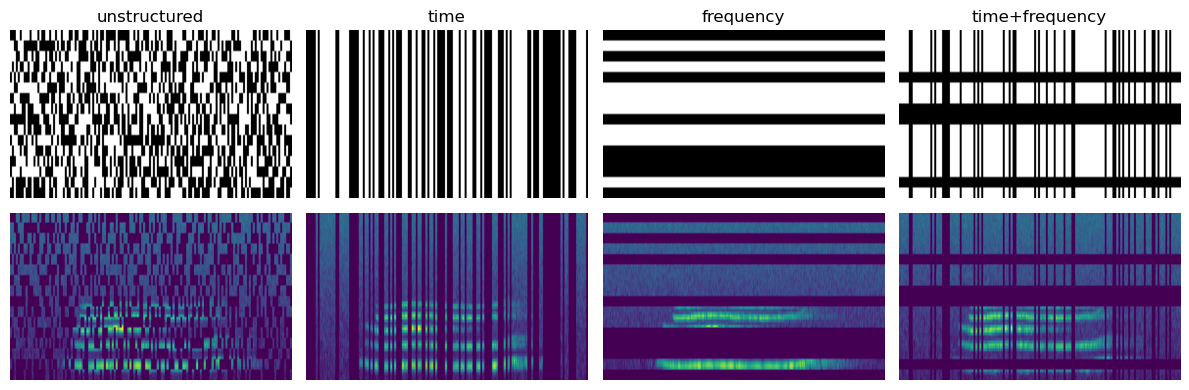

In [48]:
MIN_VALUE = torch.min(x_full)
mask_types = ["unstructured", "time", "frequency", "time+frequency"]
shape = x_full[0,:,:].shape
batch_size = 1
global_min, global_max = torch.min(x_full), torch.max(x_full)

# Initialize figure with double the number of subplots
plt.figure(figsize=(12, 4))  # Adjusted figure size for 2 rows

for idx, mask_type in enumerate(mask_types):
    
    # Generate masks
    mask_gen = MaskGenerator(shape, mask_type=mask_type, mask_percentage=50, mask_bs=batch_size)
    batch_masks = mask_gen.generate()
    mask = batch_masks[0]  # pick the first mask from the batch for visualization

    # Apply the mask
    masked_spectrogram = x_full[0,:,:] * mask
    masked_spectrogram[masked_spectrogram == 0] = MIN_VALUE

    # Plot mask in the top row
    plt.subplot(2, len(mask_types), idx + 1)  # Adjusted to 2 rows
    plt.imshow(np.rot90(mask), cmap='gray', aspect='auto')  # Plotting the mask
    plt.axis('off')
    plt.title(mask_type)

    # Plot masked spectrogram in the bottom row
    plt.subplot(2, len(mask_types), len(mask_types) + idx + 1)  # Adjusted index for bottom row
    plt.imshow(np.rot90(masked_spectrogram.detach().numpy()), cmap='viridis', aspect='auto', vmin=global_min, vmax=global_max)
    plt.axis('off')

plt.tight_layout()
plt.savefig('masks_and_spectrograms.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


### Implementation of RELAX for time-frequency based masks

In [49]:
import tqdm.notebook as tqdm

def relax(mask_percentage, mask_type, num_batches, mask_bs, input_shape, x_full, model, h_star, min_value):
    # Initialize arrays
    R = torch.zeros(576, 64)
    U = torch.zeros(576, 64)

    # Similarity measure
    pdist = nn.CosineSimilarity(dim=1)

    with torch.no_grad():
        # Calculate Importance
        for _ in tqdm.trange(num_batches, desc=f"Processing batches for importance"):
            mask_gen = MaskGenerator(shape=input_shape, mask_type=mask_type, mask_percentage=mask_percentage, mask_bs=mask_bs)
            batch_masks = mask_gen.generate()
            
            # Apply mask
            mask = batch_masks[0]
            x_mask = x_full * mask 
            x_mask[x_mask == 0] = min_value  
            x_mask = x_mask.view(6, 1, 96, 64)
            
            # Compute output for masked input
            h = model(x_mask)
            
            # Compute cosine similarity
            s = pdist(h_star, h)[:, None, None, None]
            
            # Compute importance
            R += torch.mean(s * (1 - mask), dim=(0, 1))
        
        R /= (num_batches * (mask_percentage / 100))
        
        # Calculate Uncertainty
        for _ in tqdm.trange(num_batches, desc=f"Processing batches for uncertainty"):
            mask_gen = MaskGenerator(shape=input_shape, mask_type=mask_type, mask_percentage=mask_percentage, mask_bs=mask_bs)
            batch_masks = mask_gen.generate()
            
            # Apply mask
            mask = batch_masks[0]
            x_mask = x_full * mask
            x_mask[x_mask == 0] = min_value  
            x_mask = x_mask.view(6, 1, 96, 64)
            
            # Compute output for masked input
            out = model(x_mask)
            
            # Compute cosine similarity
            s = pdist(h_star, out)[:, None, None, None]
            
            # Compute uncertainty
            var = (s - R) ** 2
            var = torch.mean(var * (1 - mask), dim=(0, 1))

            U += var
            
        U /= ((num_batches - 1) * (mask_percentage / 100))
    
    return R, U


In [50]:
# Adjustable parameters
NUM_BATCHES = 50*200
MASK_BS = 1
INPUT_SHAPE = (full_length, 64)
MIN_VALUE = torch.min(x)

## Run RELAX for time+frequency

In [51]:
MASK_PERCENTAGE = 90
MASK_TYPE = "time+frequency"

# Calling the relax function
R, U = relax(MASK_PERCENTAGE, MASK_TYPE, NUM_BATCHES, MASK_BS, INPUT_SHAPE, x_full, model, h_star, MIN_VALUE)

Processing batches for importance:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing batches for uncertainty:   0%|          | 0/10000 [00:00<?, ?it/s]

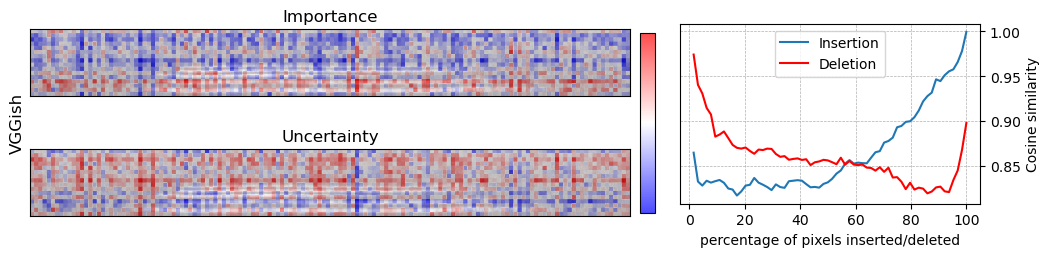

In [52]:
# Plot
mask_type = MASK_TYPE
algo = 'RELAX'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

## Run RELAX for Unstructured

In [53]:
MASK_PERCENTAGE = 70
MASK_TYPE = "unstructured"

# Calling the relax function
R, U = relax(MASK_PERCENTAGE, MASK_TYPE, NUM_BATCHES, MASK_BS, INPUT_SHAPE, x_full, model, h_star, MIN_VALUE)

Processing batches for importance:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing batches for uncertainty:   0%|          | 0/10000 [00:00<?, ?it/s]

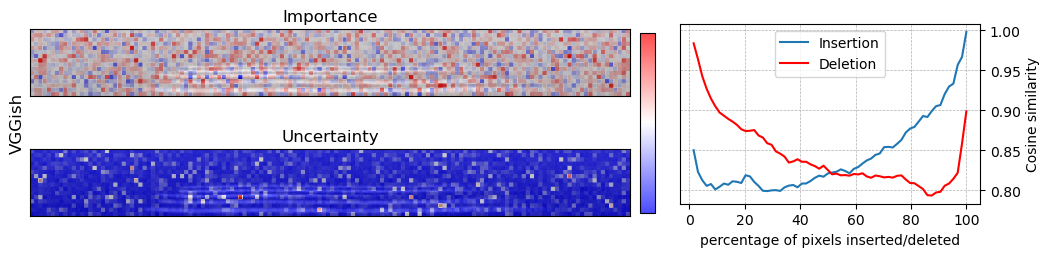

In [54]:
# Plot
mask_type = MASK_TYPE
algo = 'RELAX'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

## Run RELAX for Time

In [ ]:
MASK_PERCENTAGE = 70
MASK_TYPE = "time"

# Calling the relax function
R, U = relax(MASK_PERCENTAGE, MASK_TYPE, NUM_BATCHES, MASK_BS, INPUT_SHAPE, x_full, model, h_star, MIN_VALUE)

Processing batches for importance:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Plot
mask_type = MASK_TYPE
algo = 'RELAX'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

## Run RELAX for Frequency

In [ ]:
MASK_PERCENTAGE = 70
MASK_TYPE = "frequency"

# Calling the relax function
R, U = relax(MASK_PERCENTAGE, MASK_TYPE, NUM_BATCHES, MASK_BS, INPUT_SHAPE, x_full, model, h_star, MIN_VALUE)

In [ ]:
# Plot
mask_type = MASK_TYPE
algo = 'RELAX'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

# Noise Experiments

## Experiment 4: New noisy data

In [ ]:
# Load an audio file 
audio_path = 'data/rooster.mp3'
y, sr  = librosa.load(audio_path)

# Prepare input
x = vggish_input.waveform_to_examples(y, sr)
(n_frames, n_channels, h, w) = x.shape
full_length = n_frames * h
min_value = torch.min(x)

# Concatenate and split
x_full = torch.cat(tuple(x), dim=1)
x_split = x_full.view(1, n_frames, 96, 64)

# Plot
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, n_frames) # define the grid layout
for i in range(n_frames):
    ax_upr = fig.add_subplot(gs[0, i])
    ax_upr.imshow(np.rot90(x_split[0,i,:,:].detach().numpy()), aspect='auto')
ax_lwr = fig.add_subplot(gs[1, :])
ax_lwr.imshow(np.rot90(x_full[0,:,:].detach().numpy()), aspect='auto')
plt.tight_layout()
plt.show()

In [ ]:
SEGMENTS = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 50)
#SEGMENTS = ski.segmentation.slic(x_full[0,:,:].detach().numpy(), n_segments=150, compactness=0.1, sigma = 1 , start_label=0, channel_axis=None)

In [ ]:
R, U = SinexC_VGGish(SEGMENTS, model, x, x_full, alpha, beta)

In [ ]:
mask_type = 'Felsenswalp'
algo = 'SINEXC'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'rooster_data_{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

## Experiment: Additive noise

In [ ]:
# Load an audio file 
audio_path = 'data/whale.mp3'
y, sr  = librosa.load(audio_path)

# Add Gaussian noise to the audio
noise = np.random.normal(0, 0.001, y.shape) 
y_noisy = y + noise
import soundfile as sf 
sf.write('data/whale_noisy.mp3', y_noisy, sr)

# Prepare input
x = vggish_input.waveform_to_examples(y_noisy, sr)
(n_frames, n_channels, h, w) = x.shape
full_length = n_frames * h
min_value = torch.min(x)

# Add Gaussian noise
#noise_std_dev = 1
#noise = torch.randn(x.shape) * noise_std_dev
#x = x + noise

# Concatenate and split
x_full = torch.cat(tuple(x), dim=1)
x_split = x_full.view(1, n_frames, 96, 64)

# Plot
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, n_frames) # define the grid layout
for i in range(n_frames):
    ax_upr = fig.add_subplot(gs[0, i])
    ax_upr.imshow(np.rot90(x_split[0,i,:,:].detach().numpy()), aspect='auto')
ax_lwr = fig.add_subplot(gs[1, :])
ax_lwr.imshow(np.rot90(x_full[0,:,:].detach().numpy()), aspect='auto')
plt.tight_layout()
plt.show()

In [ ]:
SEGMENTS = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 50)
R, U = SinexC_VGGish(SEGMENTS, model, x, x_full, alpha, beta)

In [ ]:
mask_type = 'Felsenswalp'
algo = 'SINEXC'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'Noisy{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()

## Experiment: Noise reduction before SINEXC

In [ ]:
# Load an noisy audio file 
audio_path = 'data/whale_noisy.mp3'
y, sr  = librosa.load(audio_path)

# Remove noise
import noisereduce as nr
from scipy.signal import wiener
#y_filtered = wiener(y)
reduced_noise_audio = nr.reduce_noise(y=y, sr=sr)
sf.write('data/whale_noise_reduced.mp3', reduced_noise_audio, sr)

In [ ]:
# Load an audio file 
audio_path = 'data/whale_noise_reduced.mp3'
y, sr  = librosa.load(audio_path)

# Prepare input
x = vggish_input.waveform_to_examples(y, sr)
(n_frames, n_channels, h, w) = x.shape
full_length = n_frames * h
min_value = torch.min(x)


# Concatenate and split
x_full = torch.cat(tuple(x), dim=1)
x_split = x_full.view(1, n_frames, 96, 64)

# Plot
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, n_frames) # define the grid layout
for i in range(n_frames):
    ax_upr = fig.add_subplot(gs[0, i])
    ax_upr.imshow(np.rot90(x_split[0,i,:,:].detach().numpy()), aspect='auto')
ax_lwr = fig.add_subplot(gs[1, :])
ax_lwr.imshow(np.rot90(x_full[0,:,:].detach().numpy()), aspect='auto')
plt.tight_layout()
plt.show()

In [ ]:
SEGMENTS = ski.segmentation.felzenszwalb(x_full[0,:,:].detach().numpy(), sigma = 1.5, scale = 50, min_size = 50)
R, U = SinexC_VGGish(SEGMENTS, model, x, x_full, alpha, beta)

In [ ]:
mask_type = 'Felsenswalp'
algo = 'SINEXC'
fig, ax = insertion_deletion_plot_VGGish(R, U, model, x, x_full)
fig.savefig(f'Denoised_{model_name}_{algo}_masktype={mask_type}.png', dpi=300, bbox_inches='tight')
plt.show()